# Spatial Proximity

This one will allow us to determine and analyze the spatial proximity of the people within a group.

## Setup

In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from src.face_utils import detect_faces2

## Calculations

Here are some functions that are defined for our calculations:

In [8]:
def calculate_face_centers(boxes):
    """Calculate center points of detected faces"""
    centers = []
    for box in boxes:
        x1, y1, x2, y2 = box
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2
        centers.append((center_x, center_y))
    return centers

def calculate_proximity_matrix(centers):
    """Calculate pairwise distances between face centers"""
    num_faces = len(centers)
    proximity_matrix = np.zeros((num_faces, num_faces))
    
    for i in range(num_faces):
        for j in range(num_faces):
            if i != j:
                proximity_matrix[i, j] = distance.euclidean(centers[i], centers[j])
    
    return proximity_matrix

def normalize_proximity_matrix(proximity_matrix):
    """Normalize the proximity matrix to a 0-1 scale"""
    max_distance = np.max(proximity_matrix)
    if max_distance > 0:
        normalized_matrix = proximity_matrix / max_distance
    else:
        normalized_matrix = proximity_matrix
    
    # Convert to proximity (closer = higher value)
    proximity_matrix = 1 - normalized_matrix
    np.fill_diagonal(proximity_matrix, 0)  # No proximity to self
    
    return proximity_matrix

def cluster_by_proximity(proximity_matrix, threshold=0.5):
    """Cluster faces based on their proximity"""
    # Convert proximity to distance for clustering
    distance_matrix = 1 - proximity_matrix
    
    # Ensure diagonal is exactly zero (this fixes the error)
    np.fill_diagonal(distance_matrix, 0)
    
    # Use condensed form for linkage
    condensed_distance = distance.squareform(distance_matrix)
    
    # Perform hierarchical clustering
    link_matrix = linkage(condensed_distance, method='ward')
    clusters = fcluster(link_matrix, threshold, criterion='distance')
    
    return clusters

def analyze_spatial_proximity(image_path):
    """Analyze spatial proximity between faces in an image"""
    # Detect faces
    faces, boxes, image = detect_faces2(image_path)
    
    if len(faces) < 2:
        print("Need at least 2 faces to analyze proximity!")
        return None, None, None, None, None
    
    # Calculate face centers
    centers = calculate_face_centers(boxes)
    
    # Calculate proximity matrix
    proximity_matrix = calculate_proximity_matrix(centers)
    
    # Normalize proximity
    normalized_proximity = normalize_proximity_matrix(proximity_matrix)
    
    # Cluster faces
    clusters = cluster_by_proximity(normalized_proximity)
    
    return boxes, centers, normalized_proximity, clusters, image

def visualize_proximity(image, boxes, centers, proximity_matrix, clusters):
    """Visualize spatial proximity between faces"""
    plt.figure(figsize=(12, 6))
    
    # Plot original image with face boxes
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    
    # Create a colormap for clusters
    colors = plt.cm.jet(np.linspace(0, 1, len(np.unique(clusters))))
    
    # Draw boxes and connections
    for i, (box, cluster) in enumerate(zip(boxes, clusters)):
        x1, y1, x2, y2 = box
        color = colors[cluster-1]  # -1 because clusters are 1-indexed
        
        # Draw box
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                           fill=False, color=color, linewidth=2)
        plt.gca().add_patch(rect)
        plt.text(x1, y1-10, f"Face {i+1}", color='white', fontsize=10,
                 bbox=dict(facecolor=color, alpha=0.7))
        
        # Draw connections between faces
        for j, (prox, center2) in enumerate(zip(proximity_matrix[i], centers)):
            if i != j and prox > 0.5:  # Only show strong connections
                plt.plot([centers[i][0], center2[0]], 
                         [centers[i][1], center2[1]], 
                         'w-', alpha=prox, linewidth=prox*3)
    
    plt.title("Spatial Proximity Analysis")
    plt.axis("off")
    
    # Plot proximity heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(proximity_matrix, cmap='viridis')
    plt.colorbar(label="Proximity (higher = closer)")
    plt.title("Proximity Matrix")
    plt.xlabel("Face ID")
    plt.ylabel("Face ID")
    
    plt.tight_layout()
    plt.show()

# Test the spatial proximity analysis on a sample image
def test_spatial_proximity(image_path):
    """Test spatial proximity analysis on an image"""
    boxes, centers, proximity_matrix, clusters, image = analyze_spatial_proximity(image_path)
    
    if boxes is None:
        return
    
    visualize_proximity(image, boxes, centers, proximity_matrix, clusters)
    
    print("Proximity Analysis Results:")
    print(f"- Detected {len(boxes)} faces")
    print(f"- Identified {len(np.unique(clusters))} spatial clusters")
    
    # Print proximity insights
    for i in range(len(boxes)):
        close_faces = []
        for j in range(len(boxes)):
            if i != j and proximity_matrix[i, j] > 0.6:
                close_faces.append(j)
        
        if close_faces:
            print(f"- Face {i+1} is in close proximity to: Face {', Face '.join(map(str, [f+1 for f in close_faces]))}")

## Sample Test

This one is more straight forward and can just be tested on a sample image:

Using detection parameters:
  - MediaPipe confidence: 0.40
  - Haar min neighbors: 4
  - NMS threshold: 0.55
  - Filter Haar: True
  - Max Haar detections: 10
Running MediaPipe detection...
Running Haar Cascade detection...
Running face_recognition detection...
Detected 13 faces after NMS filtering


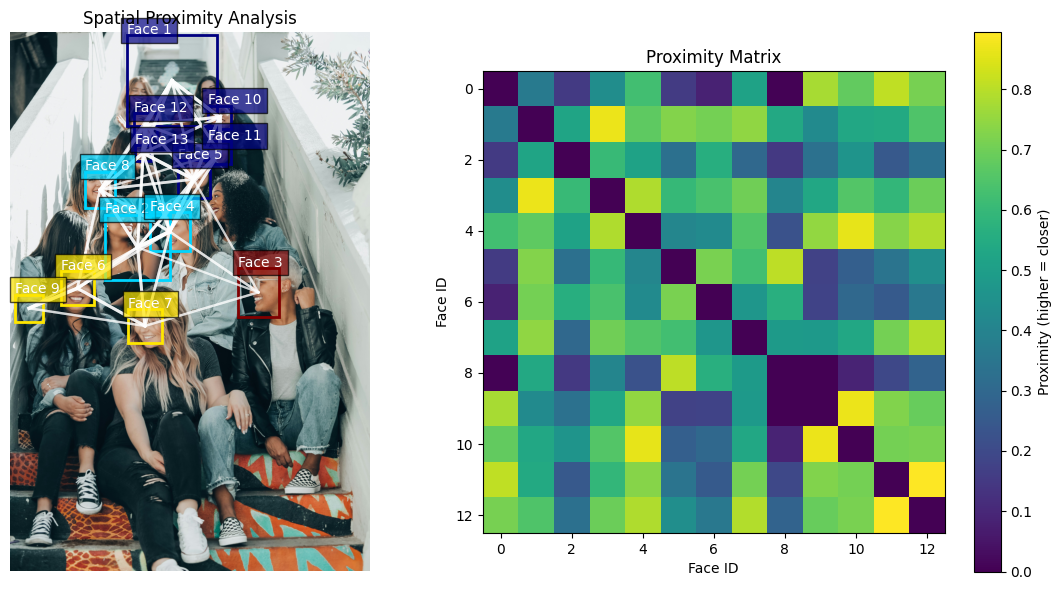

Proximity Analysis Results:
- Detected 13 faces
- Identified 4 spatial clusters
- Face 1 is in close proximity to: Face 5, Face 10, Face 11, Face 12, Face 13
- Face 2 is in close proximity to: Face 4, Face 5, Face 6, Face 7, Face 8, Face 13
- Face 3 is in close proximity to: Face 4
- Face 4 is in close proximity to: Face 2, Face 3, Face 5, Face 7, Face 8, Face 11, Face 13
- Face 5 is in close proximity to: Face 1, Face 2, Face 4, Face 8, Face 10, Face 11, Face 12, Face 13
- Face 6 is in close proximity to: Face 2, Face 7, Face 8, Face 9
- Face 7 is in close proximity to: Face 2, Face 4, Face 6
- Face 8 is in close proximity to: Face 2, Face 4, Face 5, Face 6, Face 12, Face 13
- Face 9 is in close proximity to: Face 6
- Face 10 is in close proximity to: Face 1, Face 5, Face 11, Face 12, Face 13
- Face 11 is in close proximity to: Face 1, Face 4, Face 5, Face 10, Face 12, Face 13
- Face 12 is in close proximity to: Face 1, Face 5, Face 8, Face 10, Face 11, Face 13
- Face 13 is in close p

In [9]:
# Test on an image if available
if os.path.exists('../data2/test_images'):
    test_files = os.listdir('../data2/test_images')
    if len(test_files) > 0:
        test_image = os.path.join('../data2/test_images', test_files[3])
        test_spatial_proximity(test_image)
    else:
        print("No test images found!")
else:
    print("Test images folder not found!")

## Creating proximity_utils file

In [7]:
# Create the src directory if it doesn't exist
import os
os.makedirs('src', exist_ok=True)

# Write the proximity_utils.py file with the exact functions
with open('src/proximity_utils.py', 'w') as f:
    f.write("""import numpy as np
from scipy.spatial import distance
from scipy.cluster.hierarchy import linkage, fcluster
import matplotlib.pyplot as plt
from src.face_utils import detect_faces

def calculate_face_centers(boxes):
    \"\"\"Calculate center points of detected faces\"\"\"
    centers = []
    for box in boxes:
        x1, y1, x2, y2 = box
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2
        centers.append((center_x, center_y))
    return centers

def calculate_proximity_matrix(centers):
    \"\"\"Calculate pairwise distances between face centers\"\"\"
    num_faces = len(centers)
    proximity_matrix = np.zeros((num_faces, num_faces))
    
    for i in range(num_faces):
        for j in range(num_faces):
            if i != j:
                proximity_matrix[i, j] = distance.euclidean(centers[i], centers[j])
    
    return proximity_matrix

def normalize_proximity_matrix(proximity_matrix):
    \"\"\"Normalize the proximity matrix to a 0-1 scale\"\"\"
    max_distance = np.max(proximity_matrix)
    if max_distance > 0:
        normalized_matrix = proximity_matrix / max_distance
    else:
        normalized_matrix = proximity_matrix
    
    # Convert to proximity (closer = higher value)
    proximity_matrix = 1 - normalized_matrix
    np.fill_diagonal(proximity_matrix, 0)  # No proximity to self
    
    return proximity_matrix

def cluster_by_proximity(proximity_matrix, threshold=0.5):
    \"\"\"Cluster faces based on their proximity\"\"\"
    # Convert proximity to distance for clustering
    distance_matrix = 1 - proximity_matrix
    
    # Ensure diagonal is exactly zero (this fixes the error)
    np.fill_diagonal(distance_matrix, 0)
    
    # Use condensed form for linkage
    condensed_distance = distance.squareform(distance_matrix)
    
    # Perform hierarchical clustering
    link_matrix = linkage(condensed_distance, method='ward')
    clusters = fcluster(link_matrix, threshold, criterion='distance')
    
    return clusters

def analyze_spatial_proximity(image_path):
    \"\"\"Analyze spatial proximity between faces in an image\"\"\"
    # Detect faces
    faces, boxes, image = detect_faces(image_path)
    
    if len(faces) < 2:
        print("Need at least 2 faces to analyze proximity!")
        return None, None, None, None, None
    
    # Calculate face centers
    centers = calculate_face_centers(boxes)
    
    # Calculate proximity matrix
    proximity_matrix = calculate_proximity_matrix(centers)
    
    # Normalize proximity
    normalized_proximity = normalize_proximity_matrix(proximity_matrix)
    
    # Cluster faces
    clusters = cluster_by_proximity(normalized_proximity)
    
    return boxes, centers, normalized_proximity, clusters, image

def visualize_proximity(image, boxes, centers, proximity_matrix, clusters):
    \"\"\"Visualize spatial proximity between faces\"\"\"
    plt.figure(figsize=(12, 6))
    
    # Plot original image with face boxes
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    
    # Create a colormap for clusters
    colors = plt.cm.jet(np.linspace(0, 1, len(np.unique(clusters))))
    
    # Draw boxes and connections
    for i, (box, cluster) in enumerate(zip(boxes, clusters)):
        x1, y1, x2, y2 = box
        color = colors[cluster-1]  # -1 because clusters are 1-indexed
        
        # Draw box
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                           fill=False, color=color, linewidth=2)
        plt.gca().add_patch(rect)
        plt.text(x1, y1-10, f"Face {i+1}", color='white', fontsize=10,
                 bbox=dict(facecolor=color, alpha=0.7))
        
        # Draw connections between faces
        for j, (prox, center2) in enumerate(zip(proximity_matrix[i], centers)):
            if i != j and prox > 0.5:  # Only show strong connections
                plt.plot([centers[i][0], center2[0]], 
                         [centers[i][1], center2[1]], 
                         'w-', alpha=prox, linewidth=prox*3)
    
    plt.title("Spatial Proximity Analysis")
    plt.axis("off")
    
    # Plot proximity heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(proximity_matrix, cmap='viridis')
    plt.colorbar(label="Proximity (higher = closer)")
    plt.title("Proximity Matrix")
    plt.xlabel("Face ID")
    plt.ylabel("Face ID")
    
    plt.tight_layout()
    plt.show()

def test_spatial_proximity(image_path):
    \"\"\"Test spatial proximity analysis on an image\"\"\"
    boxes, centers, proximity_matrix, clusters, image = analyze_spatial_proximity(image_path)
    
    if boxes is None:
        return
    
    visualize_proximity(image, boxes, centers, proximity_matrix, clusters)
    
    print("Proximity Analysis Results:")
    print(f"- Detected {len(boxes)} faces")
    print(f"- Identified {len(np.unique(clusters))} spatial clusters")
    
    # Print proximity insights
    for i in range(len(boxes)):
        close_faces = []
        for j in range(len(boxes)):
            if i != j and proximity_matrix[i, j] > 0.6:
                close_faces.append(j)
        
        if close_faces:
            print(f"- Face {i+1} is in close proximity to: Face {', Face '.join(map(str, [f+1 for f in close_faces]))}")
""")

print("Proximity analysis functions saved to src/proximity_utils.py")

Proximity analysis functions saved to src/proximity_utils.py
